# Homework 3

This Notebook builds on the unit commitment model introduced in [Notebook 5](https://github.com/east-winds/power-systems-optimization/tree/master/Notebooks) and the storage model introduced in [Notebook 2](https://github.com/east-winds/power-systems-optimization/tree/master/Notebooks).

First, load (or install if necessary) a set of packages you'll need for this assignment...

In [1]:
# Uncomment and run this first line if you need to install or update packages
#import Pkg; Pkg.add("JuMP"); Pkg.add("Clp"); Pkg.add("DataFrames"); Pkg.add("CSV"); Pkg.add("Plots"); Pkg.add("VegaLite")
using JuMP
using GLPK
using DataFrames
using CSV
using Plots; plotly();
using VegaLite  # to make some nice plots

#=
Function to convert JuMP outputs (technically, AxisArrays) with two-indexes to a dataframe
Inputs:
    var -- JuMP AxisArray (e.g., value.(GEN))
Reference: https://jump.dev/JuMP.jl/v0.19/containers/
=#
function value_to_df_2dim(var)
    solution = DataFrame(var.data)
    ax1 = var.axes[1]
    ax2 = var.axes[2]
    cols = names(solution)
    insertcols!(solution, 1, :r_id => ax1)
    solution = stack(solution, Not(:r_id), variable_name=:hour)
    solution.hour = foldl(replace, [cols[i] => ax2[i] for i in 1:length(ax2)], init=solution.hour)
    rename!(solution, :value => :gen)
    solution.hour = convert.(Int64,solution.hour)
    return solution
end

┌ Warning: ORCA.jl has been deprecated and all savefig functionality
│ has been implemented directly in PlotlyBase itself.
│ 
│ By implementing in PlotlyBase.jl, the savefig routines are automatically
│ available to PlotlyJS.jl also.
└ @ ORCA /Users/tombearpark/.julia/packages/ORCA/U5XaN/src/ORCA.jl:8


value_to_df_2dim (generic function with 1 method)

## Question 1 - Compare startup costs in unit commitment

**A. Code and run basic model.**

Data for this problem is stored in [`Homeworks/hw3_data`](hw3_data/).

Following the `unit_commitment_simple` modeling formulation in [Notebook 5](https://github.com/east-winds/power-systems-optimization/tree/master/Notebooks), load the above data and create a unit commitment solver function with the following set of constraints:

- Demand balance
- Minimum / maximum generator constraints (non-committed)
- Minimum / maximum generator constraints (committed)
- Three-variable commitment formulation

Note: the data (with hours 1-24) is already in local time. Hence, do not convert from GMT to GMT-8.

Run the UC for the given day and plot a stacked area chart of generation using `@vlplot` from the `VegaLite` package.

In [2]:
# Note - throughout, I include 600MW of behind the meter solar, following the previous 
# notebook

# Load the data
url_base = "https://raw.githubusercontent.com/east-winds/" * 
        "power-systems-optimization/master/Homeworks/hw3_data/"

# Helper function - loads and formats csv from the github storage location
function load_df(url_base::String, csv_name::String)
    df = DataFrame(CSV.read(download(url_base * csv_name)));
    rename!(df,lowercase.(names(df)))
    return df
end

# Run the function to load all four dataframes needed
Demand = load_df(url_base, "Demand.csv");
Fuels_data = load_df(url_base, "Fuels_data.csv");
Generators_data = load_df(url_base, "Generators_data.csv");
Generators_variability = load_df(url_base, "Generators_variability.csv");

In [3]:
# Clean up the dataframes so they are ready to be inputted into our function

# 1. Merge in fuel costs, first checking we have full matches 

# Hacky check to make sure we dont have a messy merge - sure there is a better
# way to do this
(unique(Generators_data.fuel) == 
    unique(Fuels_data.fuel) && println("Merge will be fine!")) 

gen_df = outerjoin(Generators_data, Fuels_data, on = :fuel)

rename!(gen_df, :cost_per_mmbtu => :fuel_cost)   # rename column for fuel cost
gen_df.fuel_cost[ismissing.(gen_df[:,:fuel_cost])] .= 0

# create "is_variable" column to indicate if this is a variable generation  
# (e.g. wind, solar):
gen_df.is_variable = false
gen_df[in(["onshore_wind_turbine","small_hydroelectric",
    "solar_photovoltaic"]).(gen_df.resource),
    :is_variable] .= true;

# create full name of generator (including geographic location and cluster no.)
#  for use with variable generation dataframe
gen_df.gen_full = lowercase.(gen_df.region .* "_" .* gen_df.resource .* 
        "_" .* string.(gen_df.cluster) .* ".0");

# remove generators with no capacity (e.g. new build options that 
# we'd use if this was capacity expansion problem)
gen_df = gen_df[gen_df.existing_cap_mw .> 0,:];

# 2. Convert cf data from "wide" to "long" format
gen_variable_long = stack(Generators_variability, 
                        Not(:hour), 
                        variable_name=:gen_full,
                        value_name=:cf);

Merge will be fine!


In [4]:
#=
Function to solve simple unit commitment problem (commitment equations)
Inputs:
    gen_df -- dataframe with generator info
    loads  -- load by time
    gen_variable -- capacity factors of variable generators (in "long" format)
=#
function unit_commitment_simple(gen_df, loads, gen_variable)
    UC = Model(GLPK.Optimizer)

    # We reduce the MIP gap tolerance threshold here to increase tractability
    # Here we set it to a 1% gap, meaning that we will terminate once we have 
    # a feasible integer solution guaranteed to be within 1% of the objective
    # function value of the optimal solution.
    # Note that GLPK's default MIP gap is 0.0, meaning that it tries to solve
    # the integer problem to optimality, which can take a LONG time for 
    # any complex problem. So it is important to set this to a realistic value
    set_optimizer_attribute(UC, "mip_gap", 0.01)

    # Define sets based on data
    # Note the creation of several different sets of generators for use in
    # different equations.
        # Thermal resources for which unit commitment constraints apply
    G_thermal = gen_df[gen_df[!,:up_time] .> 0,:r_id] 
        # Non-thermal resources: unit commitment constraints do not apply 
    G_nonthermal = gen_df[gen_df[!,:up_time] .== 0,:r_id]
        # Variable renewable resources
    G_var = gen_df[gen_df[!,:is_variable] .== 1,:r_id]
        # Non-variable (dispatchable) resources
    G_nonvar = gen_df[gen_df[!,:is_variable] .== 0,:r_id]
        # Non-variable and non-thermal resources
    G_nt_nonvar = intersect(G_nonvar, G_nonthermal)
        # Set of all generators (above are all subsets of this)
    G = gen_df.r_id
        # All time periods (hours) over which we are optimizing
    T = loads.hour
        # A subset of time periods that excludes the last time period
    T_red = loads.hour[1:end-1]  # reduced time periods without last one

    # Generator capacity factor time series for variable generators
    gen_var_cf = innerjoin(gen_variable, 
                    gen_df[gen_df.is_variable .== 1 , 
                        [:r_id, :gen_full, :existing_cap_mw]], 
                    on = :gen_full)
        
    # Decision variables   
    @variables(UC, begin
            # Continuous decision variables
        GEN[G, T]  >= 0     # generation
            # Bin = binary variables; 
            # the following are all binary decisions that 
            # can ONLY take the values 0 or 1
            # The presence of these discrete decisions makes this an MILP
        COMMIT[G_thermal, T], Bin # commitment status (Bin=binary)
        START[G_thermal, T], Bin  # startup decision
        SHUT[G_thermal, T], Bin   # shutdown decision
    end)
                
    # Objective function
        # Sum of variable costs + start-up costs for all generators and time 
    @objective(UC, Min, 
        sum( (gen_df[gen_df.r_id .== i,
            :heat_rate_mmbtu_per_mwh][1] * 
                gen_df[gen_df.r_id .== i,:fuel_cost][1] +
            gen_df[gen_df.r_id .== i,:var_om_cost_per_mwh][1]) * GEN[i,t] 
                        for i in G_nonvar for t in T) + 
        sum(gen_df[gen_df.r_id .== i,:var_om_cost_per_mwh][1] * GEN[i,t] 
                        for i in G_var for t in T)  + 
        sum(gen_df[gen_df.r_id .== i,:start_cost_per_mw][1] * 
            gen_df[gen_df.r_id .== i,:existing_cap_mw][1] *
            START[i,t] 
                        for i in G_thermal for t in T)
    )
    
    # Demand balance constraint (supply must = demand in all time periods)
    @constraint(UC, cDemand[t in T], 
        sum(GEN[i,t] for i in G) == loads[loads.hour .== t,:demand][1])

    # Capacity constraints 
      # 1. thermal generators requiring commitment
    @constraint(UC, Cap_thermal_min[i in G_thermal, t in T], 
        GEN[i,t] >= COMMIT[i, t] * gen_df[gen_df.r_id .== i,
                        :existing_cap_mw][1] *
                        gen_df[gen_df.r_id .== i,:min_power][1])
    @constraint(UC, Cap_thermal_max[i in G_thermal, t in T], 
        GEN[i,t] <= COMMIT[i, t] * gen_df[gen_df.r_id .== i,
                        :existing_cap_mw][1])

      # 2. non-variable generation not requiring commitment
    @constraint(UC, Cap_nt_nonvar[i in G_nt_nonvar, t in T], 
        GEN[i,t] <= gen_df[gen_df.r_id .== i,:existing_cap_mw][1])
    
      # 3. variable generation, accounting for hourly capacity factor
    @constraint(UC, Cap_var[i in 1:nrow(gen_var_cf)], 
            GEN[gen_var_cf[i,:r_id], gen_var_cf[i,:hour] ] <= 
                        gen_var_cf[i,:cf] *
                        gen_var_cf[i,:existing_cap_mw])
    
    # Unit commitment constraints
      # 1. Minimum up time
    @constraint(UC, Startup[i in G_thermal, t in T],
        COMMIT[i, t] >= sum(START[i, tt] 
                        for tt in intersect(T,
                            (t-gen_df[gen_df.r_id .== i,:up_time][1]):t)))

      # 2. Minimum down time
    @constraint(UC, Shutdown[i in G_thermal, t in T],
        1-COMMIT[i, t] >= sum(SHUT[i, tt] 
                        for tt in intersect(T,
                            (t-gen_df[gen_df.r_id .== i,:down_time][1]):t)))
 
      # 3. Commitment state
    @constraint(UC, CommitmentStatus[i in G_thermal, t in T_red],
        COMMIT[i,t+1] - COMMIT[i,t] == START[i,t+1] - SHUT[i,t+1])
    
    # Solve statement (! indicates runs in place)
    optimize!(UC)

    # Generation solution and convert to data frame 
    # with our helper function defined above
    gen = value_to_df_2dim(value.(GEN))

    # Commitment status solution and convert to data frame
    commit = value_to_df_2dim(value.(COMMIT))

    # Calculate curtailment = available wind and/or solar output that 
    # had to be wasted due to operating constraints
    curtail = innerjoin(gen_var_cf, gen, on = [:r_id, :hour])
    curtail.curt = curtail.cf .* curtail.existing_cap_mw - curtail.gen
    
    # Return the solution parameters and objective
    return (
        gen,
        commit,
        curtail,
        cost = objective_value(UC),
        status = termination_status(UC)
    )

end

unit_commitment_simple (generic function with 1 method)

In [5]:
# Solve
solution = unit_commitment_simple(gen_df, Demand, gen_variable_long);

In [6]:
# Save optimised cost for later reference 
cost = solution.cost

474378.7889767999

In [7]:
# Function to clean up the data so we can run the VLPLOT
# Adds in BTM solar and curtailment and plot results
# inputs;
#     solution: an optimised JUMP model
#     gen_df: dataframe with generators info used in the JUMP model

function plot_solution(solution, gen_df)
    sol_gen = innerjoin(solution.gen, 
                        gen_df[!, [:r_id, :resource]], 
                        on = :r_id)

    # this is basically collapsing the data
    sol_gen = combine(groupby(sol_gen, [:resource, :hour]), 
                :gen => sum)

    sol_gen[sol_gen.resource .== "solar_photovoltaic", 
        :resource] .= "_solar_photovoltaic"
    sol_gen[sol_gen.resource .== "onshore_wind_turbine", 
        :resource] .= "_onshore_wind_turbine"
    sol_gen[sol_gen.resource .== "small_hydroelectric", 
        :resource] .= "_small_hydroelectric"

    # BTM solar - we assume we have 600MW available
    btm = DataFrame(resource = repeat(["_solar_photovoltaic_btm"]; 
            outer=length(Demand.demand)), 
            hour = Demand.hour,
            gen_sum = gen_variable_long[
            gen_variable_long.gen_full .== "wec_sdge_solar_photovoltaic_1.0",
                :cf] * 600)
    append!(sol_gen, btm)

    # Curtailment
    curtail = combine(groupby(solution.curtail, [:hour]),
                :curt => sum)
    curtail.resource = "_curtailment"
    rename!(curtail, :curt_sum => :gen_sum)
    append!(sol_gen, curtail[:,[:resource, :hour, :gen_sum]])

    # plot! 
    sol_gen |>
        @vlplot(:area, 
            x=:hour, y={:gen_sum, stack=:zero}, 
            color={"resource:n", scale={scheme="category10"}})

end

plot_solution (generic function with 1 method)

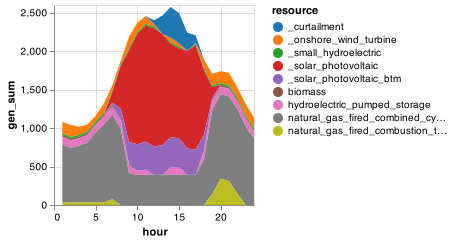

In [8]:
# Run the function to make a plot
p = plot_solution(solution, gen_df)
p

**B. Zero startup costs sensitivity**

Next, create a modified version of the generator dataframe (`gen_df_sens = copy(gen_df)`) and set the startup costs for all generators to be 0.

Rerun the UC and compare with the first solution. What are the main differences and why?

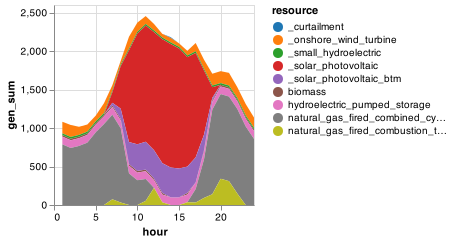

In [9]:
# Create a copy, so we can mess around with it if we want...
gen_df_sens = copy(gen_df)

# Set the start up cost to zero
gen_df_sens.start_cost_per_mw = 0

# Solve and plot this new model
solution_sens = unit_commitment_simple(gen_df_sens, Demand, gen_variable_long)
p_sens = plot_solution(solution_sens, gen_df_sens)

In [10]:
cost_sens = solution_sens.cost

396734.8851488402

In [11]:
# Define some functions to reduce copy and pasting code when we use them to plot
# other models later on. 

# Plot time series of just the natural gas generation...
function return_ts_for_resource(solution, gen_df::DataFrame, resource::String)
    sol_gen = innerjoin(solution.gen, 
                    gen_df[!, [:r_id, :resource]], 
                        on = :r_id)

    # this is basically collapsing the data
    sol_gen = combine(groupby(sol_gen, [:resource, :hour]), 
                    :gen => sum) 
    # Add in curtailment
    curtail = combine(groupby(solution.curtail, [:hour]),
                :curt => sum)
    curtail.resource = "curtailment"
    rename!(curtail, :curt_sum => :gen_sum)
    append!(sol_gen, curtail[:,[:resource, :hour, :gen_sum]])
    filter!(row -> row[:resource]==resource, sol_gen)
    return(sol_gen)
end

function transform_output(solution, string_id::String, gen_df, 
                            resource::String)
    plot_df = return_ts_for_resource(solution, gen_df, 
        resource) 
    plot_df.version = string_id
    return plot_df
end

# Plot! First plot the natural gas production
function plot_comparison(gen_string::String)
    append!(
        transform_output(solution, "baseline model", gen_df, 
            gen_string), 
        transform_output(solution_sens, "no start up costs", gen_df_sens, 
            gen_string)
    ) |> 
        @vlplot(
            :line, 
            x = :hour, 
            y = :gen_sum, 
            column = :version,
            color=:version, title = gen_string)
end

plot_comparison (generic function with 1 method)

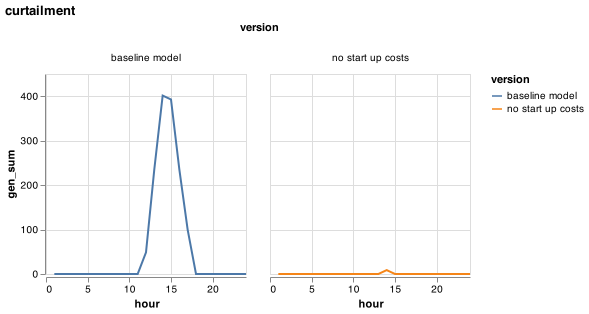

In [12]:
# Plot curtailment
plot_comparison("curtailment")

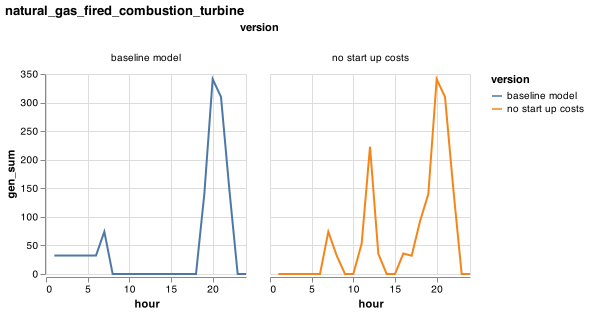

In [13]:
# Plot natural gas
plot_comparison("natural_gas_fired_combustion_turbine")

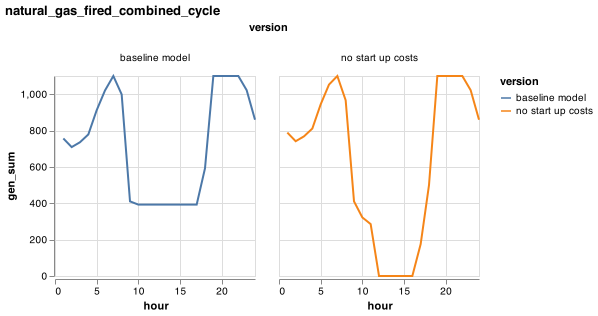

In [14]:
plot_comparison("natural_gas_fired_combined_cycle")

### Major differences / Discussion:
- When we dont have start up costs, we dont have curtailment!
This is because the system is able to more flexibly optimise! 
    - See the curtailment plot above for a visualisation of the curtailment time profile. 
    - In the baseline model, we have a large amount of curtailment during the high solar 
    period of the day. In this period, its too expensive to 
- Natural gas combustion turbine is treated as a more flexible resource, and is used more when there is 
    no start up costs. We can see this in the plot above. 
- Another interesting feature is that natural gas combined cycle plant is ramped down
to zero during the high solar period of the day if there are no start up costs. 
    - However, if there are start-up costs, it is left on during this peak, 
    even though energy is being curtailed from the system. 
    - See final plot above for a visualisation of this. 
- The production of renewable generation is not affected. 
    - Since it is zero marginal cost in either formulation, we produce as much of it as
    possible either way.

## Question 2: Implement pumped hydropower storage

In the data, we have a generator `hydroelectric_pumped_storage` which is a pumped hydro storage (PHS) facility. We have been treating it as a free resource, but in fact, it's a battery. 

The PHS equations for stored water are identical to the state of charge for the battery in Notebook 2:

$\begin{align*} 
SOC_t = SOC_{t-1} + \big(CHARGE_t * battery\_eff - \frac{DISCHARGE_t}{battery\_eff}\big)  \quad \forall t \in T
\end{align*}$

In addition, the PHS has a power capacity constraint given in the dataframe's `existing_cap_mw` variable. You will also need to implement an energy capacity constraint. 

**A. Code pumped hydropower storage constraints.**

Copy the `unit_commitment_simple` code above into a new cell below and rename the function `unit_commitment_storage`.

Reviewing [Notebook 2](https://github.com/east-winds/power-systems-optimization/tree/master/Notebooks), add in relevant constraints for charging and discharging pumped hydropower. Assume the following parameters:

- One-way efficiency is $battery_{eff} = 0.84$ (i.e., round-trip efficiency = $0.7$)
- Energy capacity = 4 x Power capacity
- Stored energy starts and ends the day at 50% capacity (you will need to code these constraints)

Indicate which equations and variables you have added and explain your steps using inline code comments (e.g. `# Comment`).

In [15]:
function unit_commitment_storage(gen_df, loads, gen_variable)
    
    UC = Model(GLPK.Optimizer)
    set_optimizer_attribute(UC, "mip_gap", 0.01)

    # Define sets based on data
    # Note the creation of several different sets of generators for use in
    # different equations.
        # Thermal resources for which unit commitment constraints apply
    G_thermal = gen_df[gen_df[!,:up_time] .> 0,:r_id] 
        # Non-thermal resources: unit commitment constraints do NOT apply 
    G_nonthermal = gen_df[gen_df[!,:up_time] .== 0,:r_id]
        # Variable renewable resources
    G_var = gen_df[gen_df[!,:is_variable] .== 1,:r_id]
        # Non-variable (dispatchable) resources
    G_nonvar = gen_df[gen_df[!,:is_variable] .== 0,:r_id]
        # Non-variable and non-thermal resources
    G_nt_nonvar = intersect(G_nonvar, G_nonthermal)
        # Set of all generators (above are all subsets of this)
    G = gen_df.r_id
        # All time periods (hours) over which we are optimizing
    T = loads.hour
        # A subset of time periods that excludes the last time period
    T_red = loads.hour[1:end-1]  # reduced time periods without last one

    # Generator capacity factor time series for variable generators
    gen_var_cf = innerjoin(gen_variable, 
                    gen_df[gen_df.is_variable .== 1 , 
                        [:r_id, :gen_full, :existing_cap_mw]], 
                    on = :gen_full)
        
    # Decision variables   
    @variables(UC, begin
            # Continuous decision variables
        GEN[G, T]  >= 0     # generation
            # Bin = binary variables; 
            # the following are all binary decisions that 
            # can ONLY take the values 0 or 1
            # The presence of these discrete decisions makes this an MILP
        COMMIT[G_thermal, T], Bin # commitment status (Bin=binary)
        START[G_thermal, T], Bin  # startup decision
        SHUT[G_thermal, T], Bin   # shutdown decision
    end)
                
    # Objective function. Objective doesn't change - we dont get direct costs  
    # or revenues from our hydro storage

        # Sum of variable costs + start-up costs for all generators and time 
    @objective(UC, Min, 
        sum( (gen_df[gen_df.r_id .== i,
            :heat_rate_mmbtu_per_mwh][1] * 
                gen_df[gen_df.r_id .== i,:fuel_cost][1] +
            gen_df[gen_df.r_id .== i,:var_om_cost_per_mwh][1]) * GEN[i,t] 
                        for i in G_nonvar for t in T) + 
        sum(gen_df[gen_df.r_id .== i,:var_om_cost_per_mwh][1] * GEN[i,t] 
                        for i in G_var for t in T)  + 
        sum(gen_df[gen_df.r_id .== i,:start_cost_per_mw][1] * 
            gen_df[gen_df.r_id .== i,:existing_cap_mw][1] *
            START[i,t] 
                        for i in G_thermal for t in T)
    )


    # new stuff related to storage 

    # set parameters defined in the problem set question
     
    hp_power_cap = gen_df.existing_cap_mw[
        gen_df.resource .=="hydroelectric_pumped_storage"][1] 
    hp_energy_cap = 4 * hp_power_cap
    battery_eff = 0.84
    start_charge = 0.5 * hp_energy_cap
    end_charge = start_charge
    inverter_eff = 1 #assume it is 1, since not specified in question 

    # Save identifier for later indexing
    hp_id = gen_df.r_id[gen_df.resource .== "hydroelectric_pumped_storage"][1]

    # add new variables for analysis
    @variables(UC, begin
        hp_power_cap    >=  CHARGE[t in T]     >= 0
        hp_power_cap    >=  DISCHARGE[t in T]  >= 0
        hp_energy_cap   >=  SOC[t in T]        >= 0
    end)

    # First define an Array of length equal to our time series to contain 
    # references to each expression
    cStateOfCharge = Array{Any}(undef, length(T))
    
    # First period state of charge:
    cStateOfCharge[1] = @constraint(UC, 
        SOC[1] == start_charge + (CHARGE[1]*battery_eff - 
            DISCHARGE[1]/battery_eff) 
    ) 
    # Final period state of charge constraint:
    cStateOfCharge[24] = @constraint(UC, 
        SOC[24] == end_charge 
    ) 
    # All other time periods, defined recursively based on prior state of 
    # charge
    for t in T[(T .> 1)]
        cStateOfCharge[t] = @constraint(UC, 
            SOC[t] == SOC[t-1] + CHARGE[t]*battery_eff - 
                DISCHARGE[t]/battery_eff
        )
    end

    # HP generation is discharge. Charging incorporated into the demand 
    # constraint below     
    @constraint(UC, hp_production[t in T],
        GEN[hp_id, t] == DISCHARGE[t]/inverter_eff)

    # Demand balance constraint (supply must = demand in all time periods)
    # note, we have added charge into this constraint. discharge is also there 
    # implicitly due to it being the generation of HP in constraint above
    
    @constraint(UC, cDemand[t in T], 
        sum(GEN[i,t] for i in G) == loads[loads.hour .== t,:demand][1] + CHARGE[t]
        )
    
    # end of new stuff related to storage
    
    # Capacity constraints 
      # 1. thermal generators requiring commitment
    @constraint(UC, Cap_thermal_min[i in G_thermal, t in T], 
        GEN[i,t] >= COMMIT[i, t] * gen_df[
                gen_df.r_id .== i,:existing_cap_mw][1] *
                        gen_df[gen_df.r_id .== i,:min_power][1])
    @constraint(UC, Cap_thermal_max[i in G_thermal, t in T], 
        GEN[i,t] <= COMMIT[i, t] * gen_df[gen_df.r_id .== i,
        :existing_cap_mw][1])

      # 2. non-variable generation not requiring commitment
    @constraint(UC, Cap_nt_nonvar[i in G_nt_nonvar, t in T], 
        GEN[i,t] <= gen_df[gen_df.r_id .== i,:existing_cap_mw][1])
    
      # 3. variable generation, accounting for hourly capacity factor
    @constraint(UC, Cap_var[i in 1:nrow(gen_var_cf)], 
            GEN[gen_var_cf[i,:r_id], gen_var_cf[i,:hour] ] <= 
                        gen_var_cf[i,:cf] *
                        gen_var_cf[i,:existing_cap_mw])
    
    # Unit commitment constraints
      # 1. Minimum up time
    @constraint(UC, Startup[i in G_thermal, t in T],
        COMMIT[i, t] >= sum(START[i, tt] 
                        for tt in intersect(T,
                            (t-gen_df[gen_df.r_id .== i,:up_time][1]):t)))

      # 2. Minimum down time
    @constraint(UC, Shutdown[i in G_thermal, t in T],
        1-COMMIT[i, t] >= sum(SHUT[i, tt] 
                        for tt in intersect(T,
                            (t-gen_df[gen_df.r_id .== i,:down_time][1]):t)))
 
      # 3. Commitment state
    @constraint(UC, CommitmentStatus[i in G_thermal, t in T_red],
        COMMIT[i,t+1] - COMMIT[i,t] == START[i,t+1] - SHUT[i,t+1])
    
    # Solve statement (! indicates runs in place)
    optimize!(UC)

    # Generation solution and convert to data frame 
    # with our helper function defined above
    gen = value_to_df_2dim(value.(GEN))

    # Commitment status solution and convert to data frame
    commit = value_to_df_2dim(value.(COMMIT))

    # Calculate curtailment = available wind and/or solar output that 
    # had to be wasted due to operating constraints
    curtail = innerjoin(gen_var_cf, gen, on = [:r_id, :hour])
    curtail.curt = curtail.cf .* curtail.existing_cap_mw - curtail.gen
    
    # Return the solution parameters and objective
    # Include a dataframe of the HP stuff, since we want to look at that in detail
    return (
        gen,
        commit,
        curtail,
        cost = objective_value(UC),
        status = termination_status(UC), 
        HP_info = DataFrame(charge = value.(CHARGE).data, 
                            discharge = value.(DISCHARGE).data, 
                            soc = value.(SOC).data
                            )
    )
end


unit_commitment_storage (generic function with 1 method)

**B. Solve the new UC with PHS and plot.**

Using the above formulation, solve for the same parameters in Problem 1 and plot. For the purposes of plotting, you will want to create two resources&mdash;PHS_charge and PHS_discharge. By convention, you could put PHS_charge on top to indicate this is increasing system load.

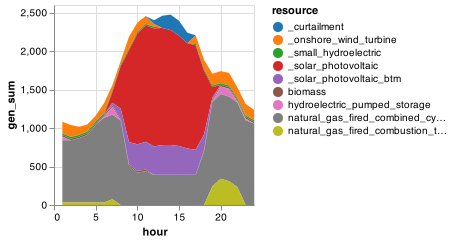

In [16]:
# Optimise!
solution_storage = unit_commitment_storage(gen_df, Demand, gen_variable_long);

# Plot output - stacked generation chart
plot_solution(solution_storage, gen_df)

In [17]:
# Note, we imediately discharge, so at the end of period one we don't have full 
# capacity hp storage
head(solution_storage.HP_info)

,charge,discharge,soc
,Float64,Float64,Float64
1,0.0,47.4628,143.497
2,0.0,0.0,143.497
3,0.0,0.0,143.497
4,0.0,0.0,143.497
5,0.0,0.0,143.497
6,0.0,20.5372,119.048


In [18]:
cost_storage = solution_storage.cost

508074.6519652801

In [19]:
# Plot comparisons across models - function for use in interpretations question below
function plot_all_three(generator::String)
    append!(append!(
        transform_output(solution, "baseline model", gen_df, 
            generator), 
        transform_output(solution_sens, "no start up costs", gen_df_sens, 
            generator)
    ), transform_output(solution_storage, "Including storage constraint", 
            gen_df, 
            generator)) |> 
        @vlplot(
            :line, 
            x = :hour, 
            y = :gen_sum, 
            column = :version,
            color=:version, 
            title=generator)
end

plot_all_three (generic function with 1 method)

**C. Interpret results**

Answer with a few sentences each of the following:

1. Compare your results to `unit_commitment_simple`. Have any commitments changed?

2. Interpret what is happening with the PHS facility during the day in terms of charging and discharging.

3. Has curtailment reduced? (Explain this in the context of the PHS operation.)

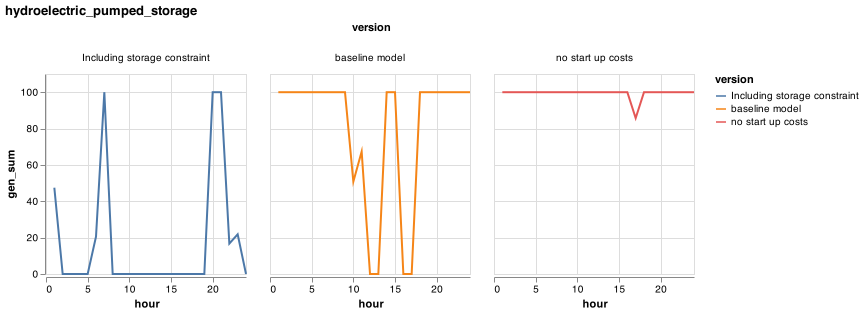

In [20]:
# Note, given the way I set up the model, this is equivalent to the discharge
plot_all_three("hydroelectric_pumped_storage")

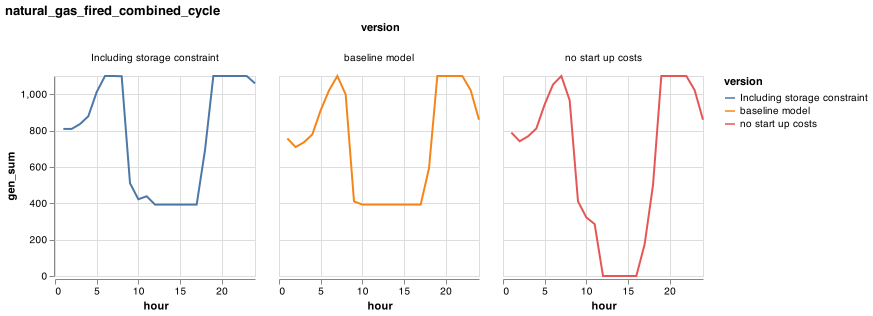

In [21]:
plot_all_three("natural_gas_fired_combined_cycle")

In [22]:
# Print out the two costs, for reference 
println(cost)
println(cost_storage)

474378.7889767999
508074.6519652801


#### 1. Compare your results to `unit_commitment_simple`. Have any commitments changed?
- The commitments have changed compared to `unit_commitment_simple`. 
    - The overall cost of the optimal solution has increased. 
    - This is due to the extra constraints on our Hydro storage facility. 
        - It now has to take power away from the rest of the system in order to be 
        able to generate in the future. 
- See the plots abovce for differences in Hydro generation, 
and natural_gas_fired_combined_cycle
generation, across the three models we have investigated. 
    - We find that including the storage constraint totally changes the way hydro is used. 
    - It is now used only at times where there is tight demand, and low solar. 
    - Before, it was treated as a free resource, so was used as much as possible 
- The profile of natural_gas_fired_combined_cycle doesn't change much. 
    - This is because it is costly to turn it off, and therefore not very flexible
    



WARN Missing type for channel "column", using "nominal" instead.
WARN Missing type for channel "column", using "nominal" instead.


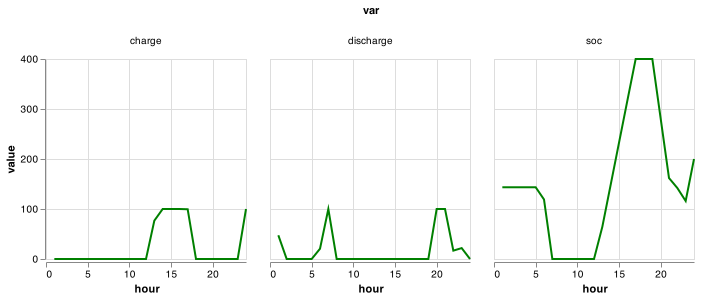

In [23]:
# Note - i'm plotting SOC, Charge, and Discharge separately from the 
# full fuel stack, since it was hard to see the relatively small 
# magnitudes on that plot. Discharge is implicitly in that plot above, since I 
# set discharge as being the generation of the hydro. Charge was also implicit, in 
# that it reflects the fact that the rest of generation is more than total demand

# Plot charge / discharge / soc 
solution_storage.HP_info.hour = 1:24
stack(solution_storage.HP_info, 
                        Not(:hour), 
                        variable_name=:var,
                        value_name=:value) |> 
    @vlplot(
        {:line, color=:green}, 
        x = :hour, 
        y = :value, 
        column = :var)

#### 2. Interpret what is happening with the PHS facility during the day in terms of charging and discharging.
- The above plot helps us understand the profile of charging and discharging the PHS. 
- Charge:
    - We charge the PHS during the period of time where solar output is very high
    and power would otherwise need to be curtailed. 
    - We discharge the PHS during morning and evening periods of high net demand

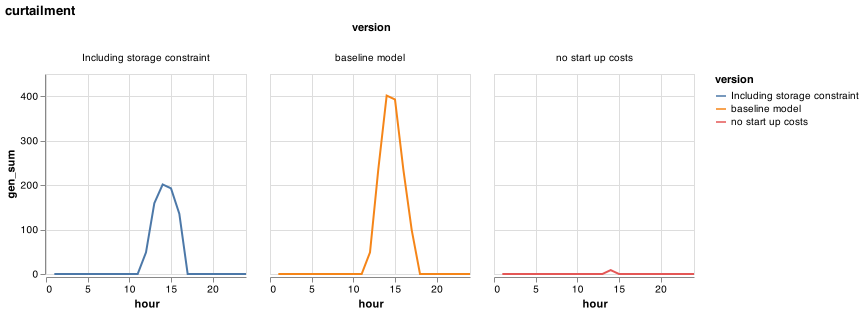

In [24]:
plot_all_three("curtailment")

#### 3. Has curtailment reduced? (Explain this in the context of the PHS operation.)
- The plots above show that one of the main changes between the two models is in the amount of curtailment. 
    - This is because when we have very high solar output, we can use this to charge up the battery. 
    - There is significantly less curtailment in the model with storage constraints. 
    - We use the PHS to shift low marginal cost energy cost production across time. 